In [2]:
import torch
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_distribution
from qiskit.quantum_info  import Pauli, SparsePauliOp, Statevector
from qiskit.providers.fake_provider import Fake127QPulseV1
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_amplitude_damping_error,
    phase_damping_error,
)
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, HGate, PhaseGate, RYGate, RXGate, RZGate, IGate, ZGate, QFT, StatePreparation
from qiskit.transpiler import CouplingMap
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import time
from qclib.gates.ldmcsu import Ldmcsu
from IPython.display import clear_output
from collections import Counter
from itertools import product
from scipy.stats import norm
from genQC.platform.qcircuit_metrics import Unitary_FrobeniusNorm
import qiskit.quantum_info as qi
import powerlaw
import itertools

In [3]:
def plot_graph(G):
    """
    Plots the graph using matplotlib.
    
    Parameters:
        G (networkx.Graph): The graph to be plotted.
    """
    # Draw the graph
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='k', edge_color='gray', width=3.0, node_size=400)
    #plt.title("Uniformly Sampled Graph")
    plt.show()

In [4]:
def prob_graph(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n-1):
        G.add_edge(i, i+1)
    G.add_edge(0, n-1)
    for (u, v, w) in G.edges(data=True):
        w['weight'] = random.randint(1, 2)
    
    return G

In [5]:
# Function to calculate distance from the origin
def distance_from_origin(x, y):
    return math.sqrt(x**2 + y**2)

def euclidean_distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

# Functions to generate different types of lattice graph
def make_38hyperbolic_graph(n):
    # Load the edge list
    edge_list_file = 'hyperbolic_graph.txt'
    edges = []
    with open(edge_list_file, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("UndirectedEdge"):
                # Extract the edge from the line
                edge = line[line.find("[")+1:line.find("]")].split(", ")
                edges.append((int(edge[0]), int(edge[1])))
    
    # Load the coordinates
    coord_file = 'hyperbolic_graph_coord.txt'
    coordinates = {}
    with open(coord_file, 'r') as file:
        for line in file:
            line = line.strip()
            if '->' in line:
                node, coord = line.split(' -> ')
                node = int(node)
                coord = coord.strip('{}').split(', ')
                x = eval(coord[0])
                y = eval(coord[1])
                coordinates[node] = (x, y)
    
    # Define the radius R
    if n < 11:
        R = 0.85
        R_update = 0.005
    else:
        R = 0.9815
        R_update = 0.0005
    #0.85(18-0:~4), 0.92(30-0:5), 0.95(57-3:6~7), 0.96(81-6:8), 0.975(108-9:9), 0.98(144-42:10), 0.9815(162-36:11), 0.982(168-24:12), 0.986(204-24:13), 0.988(252-48:14), 0.989(270-42:15), 0.99(312-42:16), 0.991(330-36:17), 0.993(420-72:18), 0.994(489-111:19), 0.9944(519-93:20)
    G = nx.Graph()
    while len(G) < n**2:
        # Filter nodes based on the distance from the origin
        nodes_within_radius = {node: coord for node, coord in coordinates.items() if distance_from_origin(*coord) <= R}
        
        # Create the graph using NetworkX
        G = nx.Graph()
        
        # Add filtered nodes
        for node in nodes_within_radius:
            G.add_node(node, pos=nodes_within_radius[node])
        
        # Add edges if both nodes are within the radius
        for edge in edges:
            if edge[0] in nodes_within_radius and edge[1] in nodes_within_radius:
                G.add_edge(edge[0], edge[1])
        
        # Remove edges have degree 2
        while min(list(dict(G.degree()).values())) == 2:
            for node, degree in dict(G.degree()).items():
                if degree == 2:
                    G.remove_node(node)
        
        # Update radius
        R += R_update
    pos = nx.get_node_attributes(G, 'pos')
    G_reindex = nx.Graph()
    for i, u in enumerate(G.nodes()):
        if not G_reindex.has_node(i):
            G_reindex.add_node(i, pos=pos[u])
        for j, v in enumerate(G.nodes()):
            if not G_reindex.has_node(j):
                G_reindex.add_node(j, pos=pos[v])
            if G.has_edge(u, v):
                G_reindex.add_edge(i, j) 
        
    return G_reindex

def make_37hyperbolic_graph(n):
    # Load the edge list
    edge_list_file37 = 'hyperbolic_graph_37.txt'
    edges37 = []
    with open(edge_list_file37, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("UndirectedEdge"):
                # Extract the edge from the line
                edge = line[line.find("[")+1:line.find("]")].split(", ")
                edges37.append((int(edge[0]), int(edge[1])))
    
    # Load the coordinates
    coord_file37 = 'hyperbolic_graph_coord_37.txt'
    coordinates37 = {}
    with open(coord_file37, 'r') as file:
        for line in file:
            line = line.strip()
            if '->' in line:
                node, coord = line.split(' -> ')
                node = int(node)
                coord = coord.strip('{}').split(', ')
                x = eval(coord[0])
                y = eval(coord[1])
                coordinates37[node] = (x, y)
    
    # Define the radius R
    if n < 11:
        R = 0.85
        R_update = 0.005
    else:
        R = 0.9815
        R_update = 0.0005
    #0.85(18-0:~4), 0.92(30-0:5), 0.95(57-3:6~7), 0.96(81-6:8), 0.975(108-9:9), 0.98(144-42:10), 0.9815(162-36:11), 0.982(168-24:12), 0.986(204-24:13), 0.988(252-48:14), 0.989(270-42:15), 0.99(312-42:16), 0.991(330-36:17), 0.993(420-72:18), 0.994(489-111:19), 0.9944(519-93:20)
    G = nx.Graph()
    while len(G) < n**2:
        # Filter nodes based on the distance from the origin
        nodes_within_radius = {node: coord for node, coord in coordinates37.items() if distance_from_origin(*coord) <= R}
        
        # Create the graph using NetworkX
        G = nx.Graph()
        
        # Add filtered nodes
        for node in nodes_within_radius:
            G.add_node(node, pos=nodes_within_radius[node])
        
        # Add edges if both nodes are within the radius
        for edge in edges37:
            if edge[0] in nodes_within_radius and edge[1] in nodes_within_radius:
                G.add_edge(edge[0], edge[1])
        
        # Remove edges have degree 2
        while min(list(dict(G.degree()).values())) == 2:
            for node, degree in dict(G.degree()).items():
                if degree == 2:
                    G.remove_node(node)
        
        # Update radius
        R += R_update
        
    pos = nx.get_node_attributes(G, 'pos')
    G_reindex = nx.Graph()
    for i, u in enumerate(G.nodes()):
        if not G_reindex.has_node(i):
            G_reindex.add_node(i, pos=pos[u])
        for j, v in enumerate(G.nodes()):
            if not G_reindex.has_node(j):
                G_reindex.add_node(j, pos=pos[v])
            if G.has_edge(u, v):
                G_reindex.add_edge(i, j) 
        
    return G_reindex

def make_45hyperbolic_graph(n):
    # Load the edge list
    edge_list_file45 = 'hyperbolic_graph_45.txt'
    edges45 = []
    with open(edge_list_file45, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith("UndirectedEdge"):
                # Extract the edge from the line
                edge = line[line.find("[")+1:line.find("]")].split(", ")
                edges45.append((int(edge[0]), int(edge[1])))
    
    # Load the coordinates
    coord_file45 = 'hyperbolic_graph_coord_45.txt'
    coordinates45 = {}
    with open(coord_file45, 'r') as file:
        for line in file:
            line = line.strip()
            if '->' in line:
                node, coord = line.split(' -> ')
                node = int(node)
                coord = coord.strip('{}').split(', ')
                x = eval(coord[0])
                y = eval(coord[1])
                coordinates45[node] = (x, y)
    
    # Define the radius R
    R = 0.83
    R_update = 0.0005
    #0.85(18-0:~4), 0.92(30-0:5), 0.95(57-3:6~7), 0.96(81-6:8), 0.975(108-9:9), 0.98(144-42:10), 0.9815(162-36:11), 0.982(168-24:12), 0.986(204-24:13), 0.988(252-48:14), 0.989(270-42:15), 0.99(312-42:16), 0.991(330-36:17), 0.993(420-72:18), 0.994(489-111:19), 0.9944(519-93:20)
    G = nx.Graph()
    while len(G) < n**2:
        # Filter nodes based on the distance from the origin
        nodes_within_radius = {node: coord for node, coord in coordinates45.items() if distance_from_origin(*coord) <= R}
        
        # Create the graph using NetworkX
        G = nx.Graph()
        
        # Add filtered nodes
        for node in nodes_within_radius:
            G.add_node(node, pos=nodes_within_radius[node])
        
        # Add edges if both nodes are within the radius
        for edge in edges45:
            if edge[0] in nodes_within_radius and edge[1] in nodes_within_radius:
                G.add_edge(edge[0], edge[1])
        
        # Remove edges have degree 2
        while min(list(dict(G.degree()).values())) == 2:
            for node, degree in dict(G.degree()).items():
                if degree == 2:
                    G.remove_node(node)
        
        # Update radius
        R += R_update
        
    pos = nx.get_node_attributes(G, 'pos')
    G_reindex = nx.Graph()
    for i, u in enumerate(G.nodes()):
        if not G_reindex.has_node(i):
            G_reindex.add_node(i, pos=pos[u])
        for j, v in enumerate(G.nodes()):
            if not G_reindex.has_node(j):
                G_reindex.add_node(j, pos=pos[v])
            if G.has_edge(u, v):
                G_reindex.add_edge(i, j)
        
    return G_reindex

def generate_triangular_lattice_layers(layers):
    # Initialize the starting equilateral triangle vertices centered at (0, 0)
    h = np.sqrt(3) / 2
    G = nx.Graph()
    node_index = 0
    for l in range(layers):
        x = -l/2
        y = 1/np.sqrt(3)+h*l
        G.add_node(node_index, pos=(x, y))
        node_index += 1
        for i in range(l):
            x += 1
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        for i in range(l+1):
            x += 1/2
            y += -h
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        for i in range(l):
            x += -1/2
            y += -h
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        for i in range(l+1):
            x += -1
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        for i in range(l):
            x += -1/2
            y += h
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        for i in range(l):
            x += 1/2
            y += h
            G.add_node(node_index, pos=(x, y))
            node_index += 1
        
        # Get positions of nodes
        pos = nx.get_node_attributes(G, 'pos')
        
        # Add edges between nodes has distance 1
        for i in G.nodes:
            for j in G.nodes:
                if i != j:
                    distance = euclidean_distance(pos[i], pos[j])
                    if distance <= 1.1:
                        G.add_edge(i, j)
        
    return G

def make_triagular_graph(n):
    # Number of layers
    layers = 15
    
    # Generate the lattice points
    G_all = generate_triangular_lattice_layers(layers)
    
    R = 2/np.sqrt(3)
    R_update = 1/(2*np.sqrt(3))
    
    G = nx.Graph()
    while len(G) < n**2:
        # Copy whole graph
        G = G_all.copy()
        pos = nx.get_node_attributes(G, 'pos')
        # Remove nodes which distance over R
        nodes_to_remove = [node for node, coords in pos.items() if distance_from_origin(coords[0], coords[1]) > R]
        G.remove_nodes_from(nodes_to_remove)
        
        # Remove edges have degree 2
        for node, degree in dict(G.degree()).items():
            if degree == 2:
                G.remove_node(node)
        
        R += R_update
    
    pos = nx.get_node_attributes(G, 'pos')
    G_reindex = nx.Graph()
    for i, u in enumerate(G.nodes()):
        if not G_reindex.has_node(i):
            G_reindex.add_node(i, pos=pos[u])
        for j, v in enumerate(G.nodes()):
            if not G_reindex.has_node(j):
                G_reindex.add_node(j, pos=pos[v])
            if G.has_edge(u, v):
                G_reindex.add_edge(i, j)
    
    return G_reindex

def make_grid_topology(rows, columns):
    # 2차원 격자 토폴로지를 표현하는 빈 그래프를 생성합니다.
    G = nx.Graph()
    
    # 격자의 각 노드에 대해 그래프에 추가하고 번호를 부여합니다.
    node_num = 0
    for i in range(rows):
        for j in range(columns):
            G.add_node(node_num, pos=(rows/2-i, columns/2-j))
            node_num += 1
    
    # 인접한 노드 사이의 연결을 추가합니다.
    for i in range(rows):
        for j in range(columns):
            node = i * columns + j  # 현재 노드의 번호
            if i > 0:
                upper_node = (i - 1) * columns + j
                G.add_edge(node, upper_node)  # 위쪽 노드와 연결
            if i < rows - 1:
                lower_node = (i + 1) * columns + j
                G.add_edge(node, lower_node)  # 아래쪽 노드와 연결
            if j > 0:
                left_node = i * columns + (j - 1)
                G.add_edge(node, left_node)  # 왼쪽 노드와 연결
            if j < columns - 1:
                right_node = i * columns + (j + 1)
                G.add_edge(node, right_node)  # 오른쪽 노드와 연결
    
    return G

In [6]:
def rx_rotation(theta):
    return np.array(
        [
            [np.cos(theta/2), -1j*np.sin(theta/2)],
            [-1j*np.sin(theta/2), np.cos(theta/2)]
        ]
    )
def x_rotation():
    return np.array(
        [
            [0, 1],
            [1, 0]
        ]
    )

def z_rotation():
    return np.array(
        [
            [1, 0],
            [0, -1]
        ]
    )

def dec_mc_gate(qc, q_list, param):
    """decompose multi controlled gate"""
    if param == 'z':
        su2_matrix = z_rotation()
    elif param == np.pi:
        su2_matrix = x_rotation()
    else:
        su2_matrix = rx_rotation(param)
    num_ctrl = len(q_list) - 1
    
    # decompose
    qc_dec = QuantumCircuit(qc.num_qubits)
    if num_ctrl == 1:
        qc_dec.crx(param, q_list[0], q_list[1])
    else:
        qc_dec.append(Ldmcsu(su2_matrix, num_ctrl), q_list)
    tqc_dec = transpile(qc_dec, basis_gates=['rz', 'rx', 'cx'], optimization_level=0)
    for i in range(len(tqc_dec)):
        qc.append(tqc_dec[i])
    
    return qc

In [7]:
def initial_params(n, graph_type = None, penalty = 1500):
    """Make initial parameters for TSP"""
    """# Cost hamiltonian
    size = len(G.nodes())
    dist_matrix = np.zeros((size, size))
    for i, u in enumerate(G.nodes()):
        for j, v in enumerate(G.nodes()):
            if i != j:
                dist_matrix[i][j] = int(G[u][v]['weight']) if G.has_edge(u, v) else penalty
    H_TSP = np.zeros((n**2, n**2))
    Hc_TSP = np.zeros((n**2, n**2))
    # Problem cost term
    for i in range(n):
        for j in range(n):
            if abs(i-j)==1 or abs(i-j)==n-1:
                for k in range(n):
                    for l in range(n):
                        H_TSP[n*i+k][n*j+l] = dist_matrix[k][l]
    
    # Constraint term
    for i in range(n):
        for j in range(n):
            H_TSP[n*i+j][n*i+j] += -4*penalty
            Hc_TSP[n*i+j][n*i+j] += -4*penalty
            for k in range(n):
                H_TSP[n*i+j][n*i+k] +=penalty
                H_TSP[n*i+j][n*k+j] +=penalty
                Hc_TSP[n*i+j][n*i+k] +=penalty
                Hc_TSP[n*i+j][n*k+j] +=penalty"""
    
    m = math.ceil(np.sqrt(n*(n+1)))
    if graph_type == 'complete':
        hardware_graph = nx.complete_graph(m**2)
    elif graph_type == 't':
        hardware_graph = make_triagular_graph(m)
    elif graph_type == 's':
        hardware_graph = make_grid_topology(m, m)
    elif graph_type == 'h37':
        hardware_graph = make_37hyperbolic_graph(m)
    elif graph_type == 'h38':
        hardware_graph = make_38hyperbolic_graph(m)
    elif graph_type == 'h45':
        hardware_graph = make_45hyperbolic_graph(m)
            
    hardware_connectivity = []
    for edge in hardware_graph.edges():
        hardware_connectivity.append((edge[0], edge[1]))
        hardware_connectivity.append((edge[1], edge[0]))
        
    return hardware_graph, CouplingMap(couplinglist=hardware_connectivity)

In [8]:
def set_ideal_noise_model(size, correcting_nodes):
    ideal_noise_model = NoiseModel()
    
    error = depolarizing_error(0.0001, 1)
    err_cx = []
    for i in range(size):
        if i in correcting_nodes:
            err_cx.append(0.0001)
        else:
            err_cx.append(0.0001)
    errors_cx = [[depolarizing_error(err1, 1).expand(
                 depolarizing_error(err2, 1))
                  for err1 in err_cx]
                   for err2 in err_cx]
    for i in range(size):
        if not i in correcting_nodes:
            ideal_noise_model.add_quantum_error(error, ['rx', 'rz', 'x'], [i])
        for j in range(n**2):
            ideal_noise_model.add_quantum_error(errors_cx[i][j], ["cx"], [i, j])
    
    # SPAM part
    p_meas = 0.1
    meas_error = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    non_meas_error = pauli_error([('X',0), ('I', 1)])
    #noise_model.add_all_qubit_quantum_error(meas_error, 'measure')
    #noise_model.add_all_qubit_quantum_error(non_meas_error, 'ideal_measure')
    
    # TRC part
    T1s = np.ones(size)*56e3
    T2s = np.ones(size)*56e3
    
    # Instruction times (in nanoseconds)
    time_u2 = 10  # (single X90 pulse)
    time_cx = []
    for i in range(size):
        if i in correcting_nodes:
            time_cx.append(30)
        else:
            time_cx.append(30)
    
    errors_rx = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
    x_error = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, err_a).expand(
                 thermal_relaxation_error(t1b, t2b, err_b))
                  for t1a, t2a, err_a in zip(T1s, T2s, time_cx)]
                   for t1b, t2b, err_b in zip(T1s, T2s, time_cx)]
    
    for j in range(size):
        if j in correcting_nodes:
            ideal_noise_model.add_quantum_error(error, "rx", [j])
            ideal_noise_model.add_quantum_error(error, "rz", [j])
            ideal_noise_model.add_quantum_error(error, "x", [j])
        else:
            ideal_noise_model.add_quantum_error(errors_rx[j], "rx", [j])
            ideal_noise_model.add_quantum_error(x_error[j], "rz", [j])
            ideal_noise_model.add_quantum_error(x_error[j], "x", [j])
        for k in range(n**2):
            ideal_noise_model.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    return ideal_noise_model

In [9]:
def w_gate(qc, n, init_q):
    """generate n unifofrm distribution"""
    qc.x(init_q)
    qc.crx(2*math.asin(np.sqrt((n-1)/n)), init_q, init_q+1)
    for i in range(1, n-1):
        qc.cx(init_q+i, init_q+i-1)
        qc.crx(2*math.asin(np.sqrt((n-1-i)/(n-i))), init_q+i, init_q+i+1)
    qc.cx(init_q+n-1, init_q+n-2)
    
    return qc

In [10]:
def init_US(n):
    """Initial state of grover"""
    qc = QuantumCircuit(n*(n+1))
    for i in range(n):
        qc = w_gate(qc, n, i*n)
            
    return qc

In [11]:
def qc_graph(n, G):
    """make oracle circuit to satisfy graph connectivity"""
    qc = QuantumCircuit(n*(n+1))
    
    # for sparse graph
    """for i in range(n-2):
        for j in range(n):
            for neighbor in G.neighbors(j):
                q_list = [i*n+j, (i+1)*n+neighbor, n**2+i]
                qc.append(XGate().control(2), q_list)
    i = n-2
    for j in range(n):
        for neighbor in G.neighbors(j):
            q_list = [i*n+j, (i+1)*n+neighbor, n**2+i]
            qc.append(XGate().control(2), q_list)
    i = n-1
    for j in range(n):
        for neighbor in G.neighbors(j):
            q_list = [neighbor, i*n+j, n**2+i]
            qc.append(XGate().control(2), q_list)"""
    
    # for dense graph
    for i in range(n-1):
        for j in range(n):
            neighbors = []
            for neighbor in G.neighbors(j):
                neighbors.append(neighbor)
            for k in range(n):
                if k not in neighbors and k != j:
                    qc.ccx(i*n+j, (i+1)*n+k, n**2+i)
                    
    i = n-1
    for j in range(n):
        neighbors = []
        for neighbor in G.neighbors(j):
            neighbors.append(neighbor)
        for k in range(n):
            if k not in neighbors and k != j:
                qc.ccx(k, i*n+j, n**2+i)
    
    return qc

In [12]:
def TSP_constraint(n):
    qc = QuantumCircuit(n*(n+2))
    q_list = list(range(n))
    q_list.append(n+1)
    q_list = np.array(q_list)
    q_list = q_list * n
    for i in range(n):
        qc.append(XGate().control(n, ctrl_state='0'*n), list(q_list+i))
    
    return qc

In [13]:
def qft_dagger(qc, n, init_q):
    """Inverse Quantum Fourier Transform circuit"""
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), init_q + m, init_q + j)
        qc.h(init_q + j)
    
    return qc

def QPE_part(G):
    """Quantum Phase Estimation part of TSP circuit"""
    n = len(G)
    qc = QuantumCircuit(n*(n+1)+1, n**2)
    m = n
    for i in range(n):
        if 2**i > 10*n:
            m = i
            break
    for i in range(m):
        qc.h(n**2+i)
    for i in range(m):
        for iter in range(2**(m-1-i)):
            for j in range(n-1):
                for (u, v, w) in G.edges(data=True):
                    angle = np.pi*w['weight']/4
                    q_list = [n**2+i, n*j+u, n*(j+1)+v]
                    qc.append(PhaseGate(angle).control(2), q_list)
                    q_list = [n**2+i, n*j+v, n*(j+1)+u]
                    qc.append(PhaseGate(angle).control(2), q_list)
            for (u, v, w) in G.edges(data=True):
                angle = np.pi*w['weight']/4
                q_list = [n**2+i, n*(n-1)+u, v]
                qc.append(PhaseGate(angle).control(2), q_list)
                q_list = [n**2+i, n*(n-1)+v, u]
                qc.append(PhaseGate(angle).control(2), q_list)
    
    qc = qft_dagger(qc, m, n**2)
    
    return qc

In [14]:
def factorial_claculator(n):
    res = 1
    for i in range(2, n+1):
        res *=i
    
    return res

In [15]:
def grover_TSP(n, G, grover_iteration, basis_gates):
    
    simulator = AerSimulator(method='matrix_product_state')
    SHOTS = 10000
    simulator.set_options(shots=SHOTS)
    
    qc = QuantumCircuit(n*(n+1)+1, n**2)
    init_state = init_US(n)
    qc_connectivity = qc_graph(n, G)
    
    """# initial state
    qc.x(n*(n+2))
    qc.h(n*(n+2))
    qc.compose(init_state, inplace=True)
    
    qc.barrier()"""
    
    for iter in range(grover_iteration):
        """# oracle
        qc.compose(qc_connectivity, inplace=True)
        q_list = list(range(n**2, n*(n+1)+1))
        qc.append(XGate().control(len(q_list)-1, ctrl_state='0'*n), q_list)
        #qc  = dec_mc_gate(qc, q_list, np.pi)
        qc.compose(qc_connectivity.inverse(), inplace=True)
        qc.barrier()"""
        
        init_diffusion = len(transpile(qc, simulator, basis_gates=basis_gates))
        
        # diffusion
        qc.compose(init_state.inverse(), inplace=True)
        for i in range(n**2):
            qc.x(i)
        q_list = list(range(n**2))
        #qc = dec_mc_gate(qc, q_list, 'z')
        qc.append(ZGate().control(n**2-1), q_list)
        for i in range(n**2):
            qc.x(i)
        qc.compose(init_state, inplace=True)
    
    tqc = transpile(qc, simulator, basis_gates=basis_gates)
    len_circuit = len(tqc)
    
    # measure
    for i in range(n**2):
        tqc.measure(i, i)
    
    # Run simulator
    result = simulator.run(tqc).result()
    counts = result.get_counts(0)
    #plot_distribution(counts, figsize=(7, 8), sort='value_desc', number_to_keep=20)
    #qc.draw('mpl')
    
    return qc, counts#, init_diffusion, len_circuit

In [202]:
n = 4
G = prob_graph(n)
G.add_edge(1, 3)
qc, ideal_counts = grover_TSP(n, G, 1, ['x', 'rx', 'rz', 'cx'])

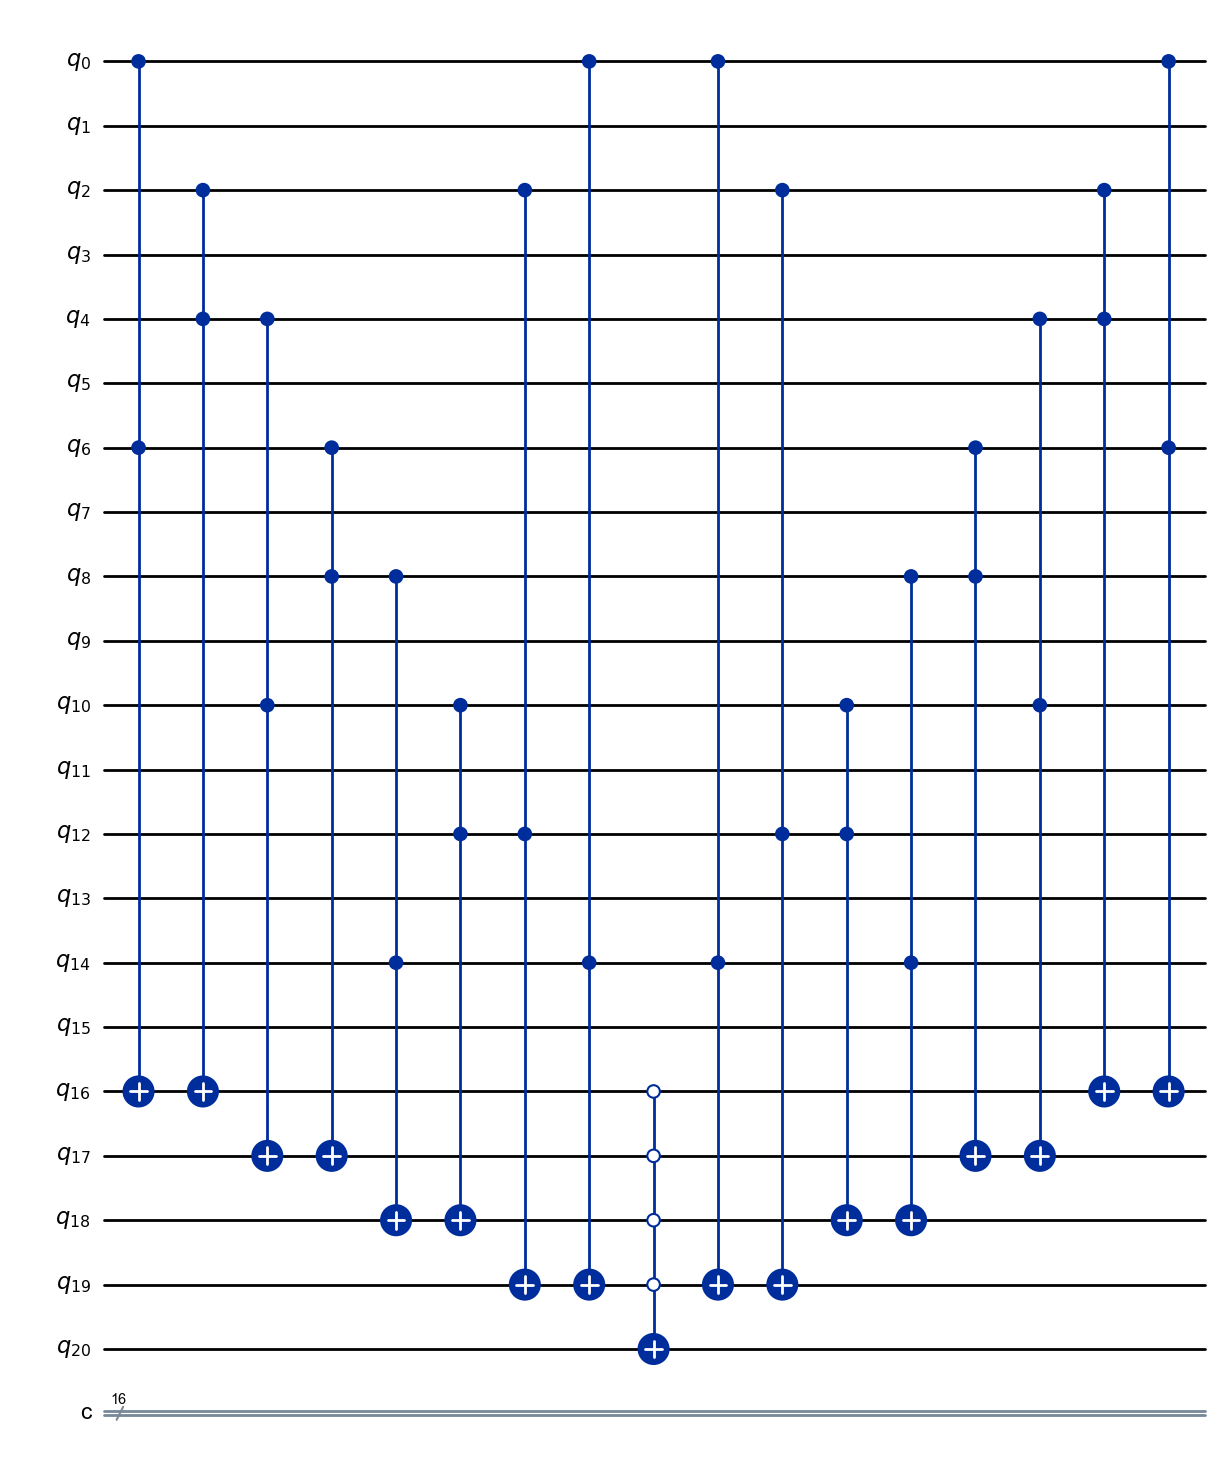

In [218]:
qc.draw('mpl')

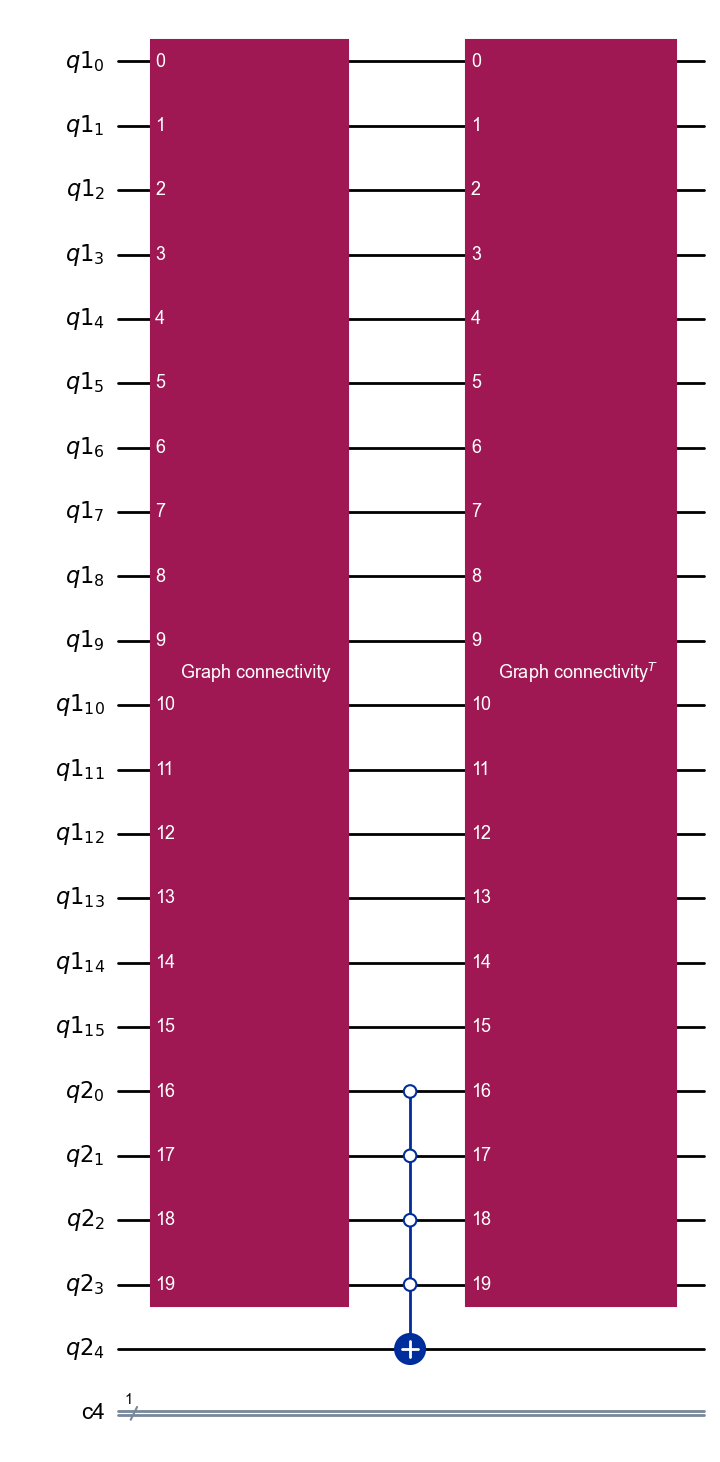

In [228]:
box_gate = QuantumCircuit(20, name='Graph connectivity')
box_gate_instruction = box_gate.to_instruction()
box_gate2 = QuantumCircuit(20, name=r'Graph connectivity$^T$')
box_gate2_instruction = box_gate2.to_instruction()

qreg1 = QuantumRegister(16, 'q1')
qreg2 = QuantumRegister(5, 'q2')
test_qc = QuantumCircuit(qreg1, qreg2, ClassicalRegister(1))
q_list = qreg1[:]
q_list.extend(qreg2[:4])
test_qc.append(box_gate_instruction, q_list)
test_qc.append(XGate().control(n, ctrl_state='0'*n), qreg2)
test_qc.append(box_gate2_instruction, q_list)

test_qc.draw('mpl')

In [35]:
ideal_simulator = AerSimulator(method='matrix_product_state')
SHOTS = 10000
ideal_simulator.set_options(shots=SHOTS)

In [ ]:
error_list = []
counts_list = []
for i in range(n**2):
    qc.measure(i, i)
for graph_type in ['s', 't', 'h37', 'h38']:#'complete', 
    print('graph_type =', graph_type)
    hardware_graph, couplingmap = initial_params(n, graph_type=graph_type)
    
    itqc = transpile(qc, ideal_simulator, basis_gates=['x', 'rx', 'rz', 'cx'], coupling_map=couplingmap, optimization_level=3)
    print('complete transpile')
    
    # Run simulator
    iresult = ideal_simulator.run(itqc).result()
    icounts = iresult.get_counts(0)
    print('complete ideal simulate')
    
    noise_model = set_ideal_noise_model(len(hardware_graph), [])
    simulator = AerSimulator(method='matrix_product_state', noise_model=noise_model)
    simulator.set_options(shots=SHOTS)
    
    tqc = transpile(qc, simulator, basis_gates=['x', 'rx', 'rz', 'cx'], coupling_map=couplingmap, optimization_level=3)
    print('complete transpile')
    
    # Run simulator
    result = simulator.run(tqc).result()
    counts = result.get_counts(0)
    print('complete noisy simulate')
    
    ideal_key = list(icounts.keys())
    err_rate = 0
    for key, count in counts.items():
        if key in ideal_key:
            err = icounts[key] - count
            if err > 0:
                err_rate += err
    
    err_rate = err_rate/SHOTS
    print(err_rate)
    error_list.append(err_rate)
    counts_list.append(counts)

In [40]:
print(counts)

{'101110101': 1, '010111010': 20, '001010100': 663, '010001100': 668, '001000101': 6, '100000010': 53, '100011010': 26, '010010010': 73, '011000100': 6, '001110000': 8, '100001011': 14, '001001110': 11, '100010001': 658, '000001100': 37, '110100100': 18, '001100010': 662, '100100001': 82, '001110011': 3, '001001111': 6, '100001010': 745, '100010010': 71, '000100000': 5, '010010001': 93, '100100101': 9, '001100110': 11, '001001001': 84, '010111100': 24, '001010110': 18, '101101000': 1, '010001010': 97, '101110011': 2, '001010010': 103, '010010000': 25, '000111111': 8, '000100001': 43, '000001010': 47, '001110010': 45, '100010011': 10, '000010011': 4, '100110010': 20, '001010000': 24, '101110001': 8, '010111110': 3, '010010100': 95, '100001101': 10, '001110110': 5, '100010111': 23, '001001100': 78, '011010011': 2, '000011110': 1, '101010010': 22, '100100011': 9, '001100000': 19, '010000100': 38, '111101111': 1, '101001110': 3, '000001000': 8, '010100001': 669, '010010111': 11, '001110101

In [38]:
print(error_list)

[0.3387, 0.5154, 0.5672, 0.5951, 0.5847]


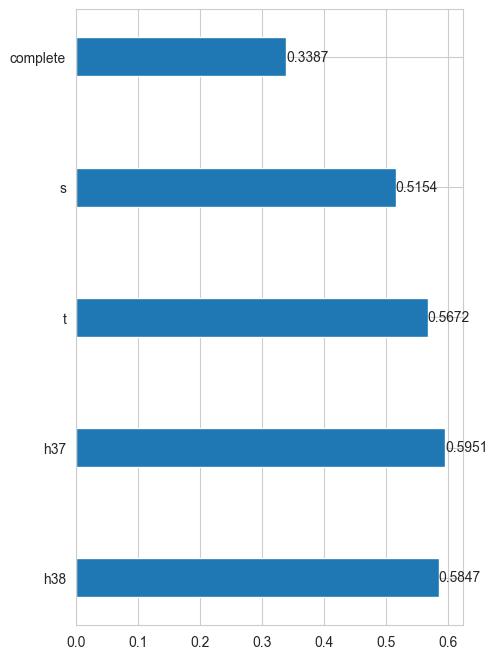

In [39]:
plt.figure(figsize=(5, 8))
plt.barh(['complete', 's', 't', 'h37', 'h38'][::-1], error_list[::-1], height=0.3)
for index, value in enumerate(error_list[::-1]):
    plt.text(value, index, str(value), va='center', ha='left')

In [ ]:
"""distribution of # of gates"""

for i in range(n**2):
    qc.measure(i, i)
for graph_type in ['complete', 's', 't', 'h37', 'h38']:
    print('graph_type =', graph_type)
    hardware_graph, couplingmap = initial_params(n, graph_type=graph_type)
    
    itqc = transpile(qc, ideal_simulator, basis_gates=['x', 'rx', 'rz', 'cx'], coupling_map=couplingmap, optimization_level=3)
    print('complete transpile')
    num_gate = []
    dist_2q = []
    for i in range(len(itqc)):
        if itqc[i].operation.name == 'barrier':
            continue
        if itqc[i].operation.name == 'cx':
            dist_2q.extend([qubit._index for qubit in itqc[i].qubits])
        num_gate.extend([qubit._index for qubit in itqc[i].qubits])
    counter = Counter(num_gate)
    print(np.sum(counter))
    # 빈도수에 따라 정렬
    res = sorted(list(counter.values()), reverse=True)
    plt.figure(figsize=(9, 4))
    # 히스토그램 플롯
    plt.bar(range(len(res)), res)
    plt.grid(False)
    plt.xlabel(f'nodes', fontsize=17, labelpad=12)
    plt.ylabel('# of gates', fontsize=17, labelpad=12)
    plt.ylim(0)
    #plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tick_params(labelsize=16)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.legend(fontsize=16)
    plt.show()
    counter = Counter(dist_2q)
    # 빈도수에 따라 정렬
    res = sorted(list(counter.values()), reverse=True)
    plt.figure(figsize=(9, 4))
    # 히스토그램 플롯
    plt.bar(range(len(res)), res)
    plt.grid(False)
    plt.xlabel(f'nodes', fontsize=17, labelpad=12)
    plt.ylabel('# of 2-qubit gates', fontsize=17, labelpad=12)
    plt.ylim(0)
    #plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tick_params(labelsize=16)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.legend(fontsize=16)
    plt.show()

In [ ]:
"""draw indexed coupling graph"""

for i in range(n**2):
    qc.measure(i, i)
for graph_type in ['s', 't', 'h37', 'h38']:#'complete', 
    print('graph_type =', graph_type)
    hardware_graph, couplingmap = initial_params(n, graph_type=graph_type)
    
    itqc = transpile(qc, ideal_simulator, basis_gates=['x', 'rx', 'rz', 'cx'], coupling_map=couplingmap, optimization_level=3)
    print('complete transpile')
    
    num_gate = []
    dist_2q = []
    for i in range(len(itqc)):
        if itqc[i].operation.name == 'barrier':
            continue
        if itqc[i].operation.name == 'cx':
            dist_2q.extend([qubit._index for qubit in itqc[i].qubits])
        num_gate.extend([qubit._index for qubit in itqc[i].qubits])
    counter = Counter(num_gate)
    sorted_keys = sorted(counter, key=counter.get, reverse=True)
    labels = {}
    for i, sorted_key in enumerate(sorted_keys):
        labels[sorted_key] = f'{i+1}'
    pos = nx.get_node_attributes(hardware_graph, 'pos')
    nx.draw(hardware_graph, pos, with_labels=False, node_color='k', edge_color='gray', width=3.0, node_size=400)
    nx.draw_networkx_labels(hardware_graph, pos, labels, font_size=15, font_color='w')
    plt.show()

In [194]:
# Plot overlapping bar plots for control qubits 3, 9, and 15
def plot_overlapping_depth_distributions(distributions_2q, distributions_total, max_qubits, title):
    plt.figure(figsize=(10, 6))
    
    # Create x axis based on the maximum number of qubits
    x = np.arange(max_qubits)

    # Plot for control qubits 3, 9, 15 with different colors and transparency
    colors = ['b', 'g', 'r']  # Reverse order of colors (smallest control qubits will be on top)
    labels = ['# of 2-q gates at n6', '# of 2-q gates at n5', '# of 2-q gates at n4']  # Reverse order of labels
    
    # Reverse plotting order to ensure smaller control qubits are on top
    for i, dist in enumerate(reversed(distributions_2q)):
        # Right-align the distribution by padding with zeros and reversing the array to get smaller values on the right
        padded_dist = np.pad(sorted(dist, reverse=True), (max_qubits - len(dist), 0), 'constant')
        plt.bar(x, padded_dist, color=colors[i], label=labels[i], alpha=0.6, width=0.8)
    padded_dist = np.pad(sorted(distributions_total, reverse=True), (max_qubits - len(distributions_total), 0), 'constant')
    plt.bar(x, padded_dist, color='grey', label='# of all gates at n=6', alpha=0.6, width=0.8)

    plt.xlabel('Qubits (Right-aligned)', fontsize=22, labelpad=12)
    plt.ylabel('Depth', fontsize=22, labelpad=12)
    plt.tick_params(labelsize=16)
    #plt.title(title)
    plt.legend(fontsize=16)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)
    plt.show()

In [183]:
# Define function to measure depth distribution across qubits after transpiling
def qubit_depth_distribution(circuit, simulator, optimization_level=3, coupling_map=None):
    # Transpile the circuit for the specific backend and coupling map (connectivity)
    transpiled_circuit = transpile(circuit, backend=simulator, optimization_level=optimization_level, basis_gates=['x', 'rx', 'rz', 'cx'])
    
    # Initialize depth counters for each qubit
    num_qubits = transpiled_circuit.num_qubits
    depth_per_qubit = [0] * num_qubits
    gate_2q_per_qubit = [0] * num_qubits
    
    # Iterate over the operations in the transpiled circuit
    for instruction in transpiled_circuit.data:
        qubits = instruction.qubits  # Extract qubits from the instruction
        if instruction.operation.name == 'cx':
            for qubit in qubits:
                gate_2q_per_qubit[qubit._index] += 1
        for qubit in qubits:
            depth_per_qubit[qubit._index] += 1  # Increment depth for the affected qubits

    return depth_per_qubit, gate_2q_per_qubit

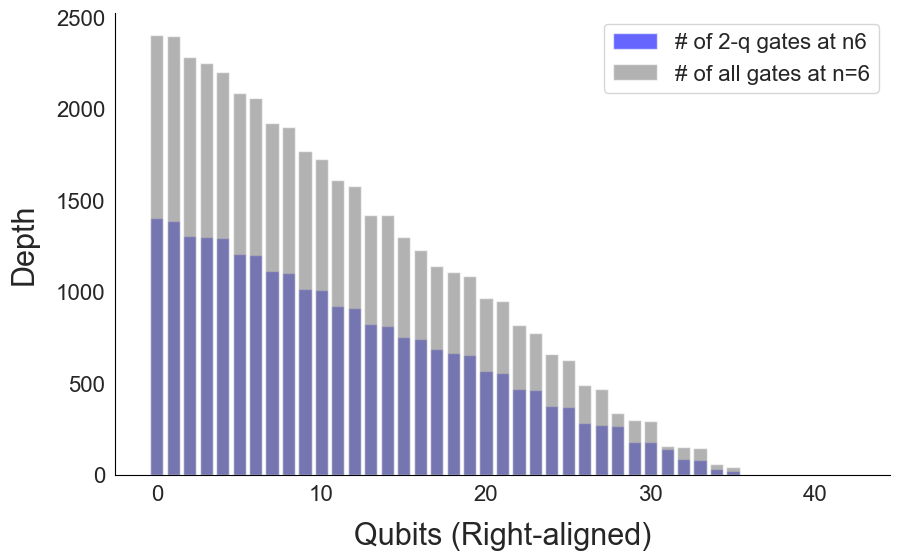

In [240]:
# Analyze for control qubits 3, 9, 15
distributions_all_to_all = []

for n in [6]:
    G = nx.complete_graph(n)
    G.remove_edge(0, 1)
    circuit, _ = grover_TSP(n, G, 1, ['x', 'rx', 'rz', 'cx'])

    # All-to-All Connectivity
    dist_all = qubit_depth_distribution(circuit, ideal_simulator)
    distributions_all_to_all.append(dist_all[1])

# Plot depth distributions for each lattice type
plot_overlapping_depth_distributions(distributions_all_to_all, dist_all[0], 43, 'Oracle part')

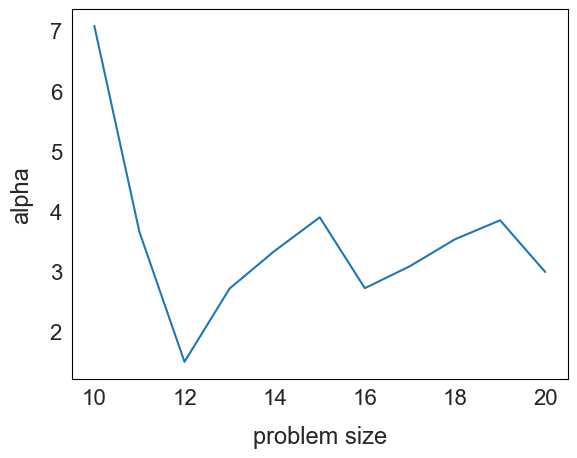

In [25]:
alpha = []
for n in range(10, 21):
    qc_test = QuantumCircuit(n)
    qc_test.append(XGate().control(n-1), range(n))
    transpiled_qc = transpile(qc_test, basis_gates=['x', 'rx', 'rz', 'cx'], optimization_level=3)
    num_gate = []
    for i in range(len(transpiled_qc)):
        if transpiled_qc[i].operation.name == 'barrier':
            continue
        num_gate.extend([qubit._index for qubit in transpiled_qc[i].qubits])
    counter = Counter(num_gate)
    # 빈도수에 따라 정렬
    res = sorted(list(counter.values()), reverse=True)
    fit = powerlaw.Fit(res)
    alpha.append(fit.alpha)
plt.plot(range(10, 21), alpha)
plt.xlabel(f'problem size', fontsize=17, labelpad=12)
plt.ylabel('alpha', fontsize=17, labelpad=12)
#plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tick_params(labelsize=16)
#plt.legend(fontsize=16)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.grid(False)

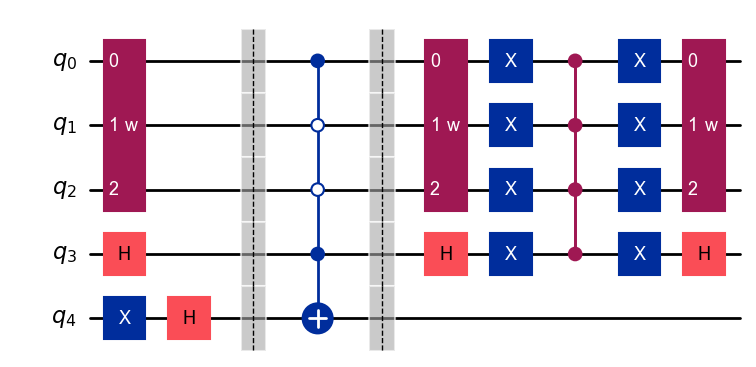

In [103]:
"""visualizing the circuit"""

wgate = QuantumCircuit(3, name='w')
wgate_instruction = wgate.to_instruction()
wgate_inverse = QuantumCircuit(3, name=r'$w^(-1)$')
wgate_inverse_instruction = wgate.to_instruction()

vis_circuit = QuantumCircuit(5)
# init part
vis_circuit.append(wgate_instruction, range(3))
vis_circuit.h(3)
vis_circuit.x(4)
vis_circuit.h(4)
vis_circuit.barrier()

# oracle part
vis_circuit.compose(oracle_part, inplace=True)
vis_circuit.barrier()

# diffusion part
vis_circuit.append(wgate_inverse_instruction, range(3))
vis_circuit.h(3)
for i in range(4):
    vis_circuit.x(i)
vis_circuit.append(ZGate().control(3), range(4))
for i in range(4):
    vis_circuit.x(i)
vis_circuit.append(wgate_instruction, range(3))
vis_circuit.h(3)

vis_circuit.draw('mpl')

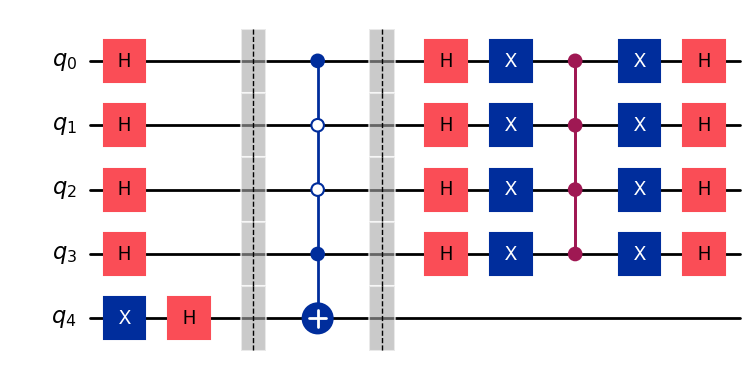

In [104]:
"""visualizing the circuit"""

vis_circuit = QuantumCircuit(5)
# init part
for i in range(4):
    vis_circuit.h(i)
vis_circuit.x(4)
vis_circuit.h(4)
vis_circuit.barrier()

# oracle part
vis_circuit.compose(oracle_part, inplace=True)
vis_circuit.barrier()

# diffusion part
for i in range(4):
    vis_circuit.h(i)
for i in range(4):
    vis_circuit.x(i)
vis_circuit.append(ZGate().control(3), range(4))
for i in range(4):
    vis_circuit.x(i)
for i in range(4):
    vis_circuit.h(i)

vis_circuit.draw('mpl')

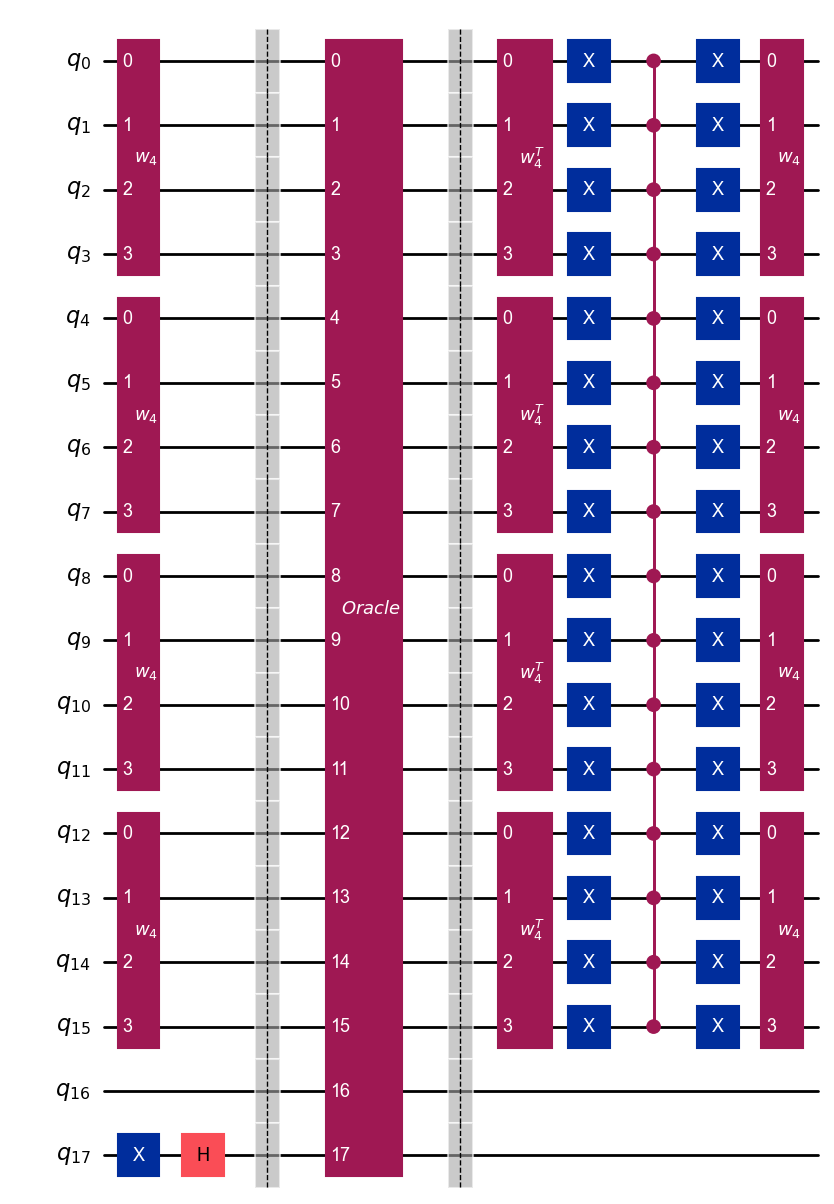

In [283]:
"""visualizing the circuit"""

n = 4
wgate = QuantumCircuit(n, name=rf'$w_{n}$')
wgate_instruction = wgate.to_instruction()
wgate_inverse = QuantumCircuit(n, name=rf'$w_{n}^T$')
wgate_inverse_instruction = wgate_inverse.to_instruction()
con_gate = QuantumCircuit(n**2+2, name=r'$Oracle$')
con_gate_instruction = con_gate.to_instruction()

vis_circuit = QuantumCircuit(n**2+2)
# init part
for i in range(n):
    vis_circuit.append(wgate_instruction, range(i*n, (i+1)*n))
vis_circuit.x(n**2+1)
vis_circuit.h(n**2+1)
vis_circuit.barrier()

# oracle part
vis_circuit.append(con_gate_instruction, range(n**2+2))
vis_circuit.barrier()

# diffusion part
for i in range(n):
    vis_circuit.append(wgate_inverse_instruction, range(i*n, (i+1)*n))
for i in range(n**2):
    vis_circuit.x(i)
vis_circuit.append(ZGate().control(n**2-1), range(n**2))
for i in range(n**2):
    vis_circuit.x(i)
for i in range(n):
    vis_circuit.append(wgate_instruction, range(i*n, (i+1)*n))

vis_circuit.draw('mpl')

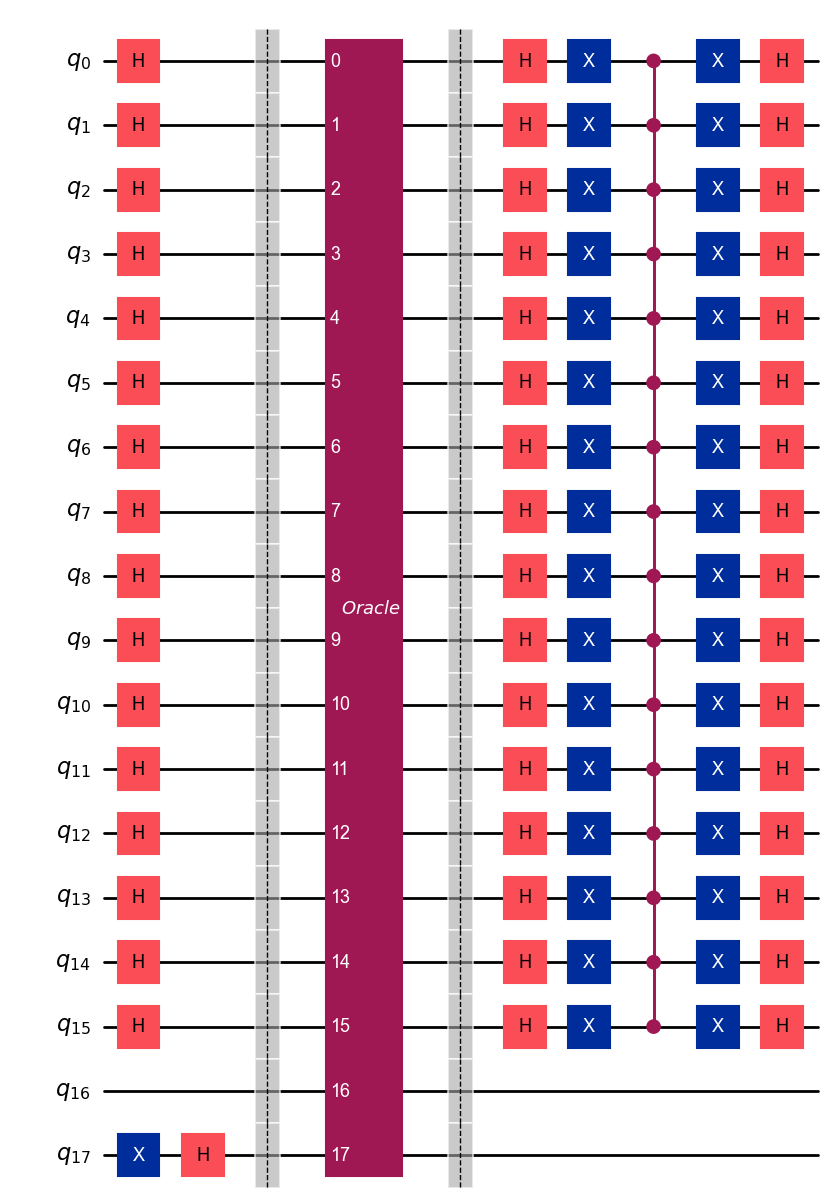

In [19]:
"""visualizing the circuit"""

n = 4
con_gate = QuantumCircuit(n**2+2, name=r'$Oracle$')
con_gate_instruction = con_gate.to_instruction()

vis_circuit = QuantumCircuit(n**2+2)
# init part
for i in range(n**2):
    vis_circuit.h(i)
vis_circuit.x(n**2+1)
vis_circuit.h(n**2+1)
vis_circuit.barrier()

# oracle part
vis_circuit.append(con_gate_instruction, range(n**2+2))
vis_circuit.barrier()

# diffusion part
for i in range(n**2):
    vis_circuit.h(i)
for i in range(n**2):
    vis_circuit.x(i)
vis_circuit.append(ZGate().control(n**2-1), range(n**2))
for i in range(n**2):
    vis_circuit.x(i)
for i in range(n**2):
    vis_circuit.h(i)

vis_circuit.draw('mpl')

In [110]:
def h_bar_plot(keys, values):
    plt.figure(figsize=(4, 8))
    
    # 가로 막대 그래프 그리기
    plt.barh(keys, values, color=['red' if v < 0 else 'green' for v in values], height=1, edgecolor='none')
    
    # 중앙선을 그리기 위해 y=0 선 추가
    plt.axvline(0, color='black', linewidth=0.8)
    
    # 그래프 제목 및 레이블 설정
    plt.xlim(-1, 1)
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor('black')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.grid(False)
    
    # 그래프 출력
    plt.show()

In [17]:
bitstrings = [''.join(bits) for bits in itertools.product('01', repeat=4)]

In [ ]:
values = [1/4]*16
h_bar_plot(bitstrings, values)
values[9] = -1/4
h_bar_plot(bitstrings, values)
values = [1/8]*16
values[0] = 7/8
for i in [2, 4, 6, 11, 13, 15]:
    values[i] = -1/8
h_bar_plot(bitstrings, values)
values[0] = -7/8
h_bar_plot(bitstrings, values)
values = [-3/16]*16
values[9] = -11/16
h_bar_plot(bitstrings, values)

values = [0]*16
for i in [1, 2, 3, 9, 10, 11]:
    values[i] = 1/np.sqrt(6)
h_bar_plot(bitstrings, values)
values[9] = - 1/np.sqrt(6)
h_bar_plot(bitstrings, values)
values = [0]*16
values[0] = 2/3
values[8] = 1/3
values[2] = -np.sqrt(2)/3
values[10] = np.sqrt(2)/3
h_bar_plot(bitstrings, values)
values[0] = -2/3
h_bar_plot(bitstrings, values)
values = [0]*16
for i in [1, 2, 3, 10, 11]:
    values[i] = - 1/(3*np.sqrt(6))
values[9] = - 7/(3*np.sqrt(6))
h_bar_plot(bitstrings, values)

In [112]:
init_h = QuantumCircuit(n*(n+1)+1)
for i in range(n**2):
    init_h.h(i)
init_h.x(n*(n+1))
init_h.h(n*(n+1))

init_w = QuantumCircuit(n*(n+1)+1)
for i in range(n):
    init_w = w_gate(init_w, n, i*n)
init_w.x(n*(n+1))
init_w.h(n*(n+1))

G = prob_graph(n)
G.add_edge(0, 2)
con_part = qc_graph(n, G)
oracle_part = QuantumCircuit(n*(n+1)+1)
oracle_part.compose(con_part, inplace=True)
oracle_part.append(XGate().control(n, ctrl_state='0'*n), range(n**2, n*(n+1)+1))
oracle_part.compose(con_part.inverse(), inplace=True)

diff = QuantumCircuit(n*(n+1)+1)
diff.append(ZGate().control(n**2-1), range(n**2))

In [21]:
ideal_simulator = AerSimulator(method='matrix_product_state')
SHOTS = 10000
ideal_simulator.set_options(shots=SHOTS)

In [ ]:
counts_h = []

qc = QuantumCircuit(n*(n+1)+1, n**2)
qc.compose(init_h, inplace=True)

tqc = transpile(qc, ideal_simulator, optimization_level=3)
for i in range(n**2):
    tqc.measure(i, i)
# Run simulator
result = ideal_simulator.run(tqc).result()
counts_h.append(result.get_counts(0))
print('complete init')

for iter in range(3):
    qc.compose(oracle_part, inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_h.append(result.get_counts(0))
    print('complete oracle')
    
    qc.compose(init_h, inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_h.append(result.get_counts(0))
    print('complete init dagger')
    
    for i in range(n**2):
        qc.x(i)
    qc.compose(diff, inplace=True)
    for i in range(n**2):
        qc.x(i)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_h.append(result.get_counts(0))
    print('complete diffusion')
    
    qc.compose(init_h, inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_h.append(result.get_counts(0))
    print('complete diffusion init part')

complete init
complete oracle
complete init dagger
complete diffusion
complete diffusion init part
complete oracle
complete init dagger
complete diffusion
complete diffusion init part
complete oracle
complete init dagger
complete diffusion


In [ ]:
counts_w = []

qc = QuantumCircuit(n*(n+1)+1, n**2)
qc.compose(init_w, inplace=True)

tqc = transpile(qc, ideal_simulator, optimization_level=3)
for i in range(n**2):
    tqc.measure(i, i)
# Run simulator
result = ideal_simulator.run(tqc).result()
counts_w.append(result.get_counts(0))
print('complete init')

for iter in range(3):
    qc.compose(oracle_part, inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_w.append(result.get_counts(0))
    print('complete oracle')
    
    qc.compose(init_w.inverse(), inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_w.append(result.get_counts(0))
    print('complete init dagger')
    
    for i in range(n**2):
        qc.x(i)
    qc.compose(diff, inplace=True)
    for i in range(n**2):
        qc.x(i)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_w.append(result.get_counts(0))
    print('complete diffusion')
    
    qc.compose(init_w, inplace=True)
    
    tqc = transpile(qc, ideal_simulator, optimization_level=3)
    for i in range(n**2):
        tqc.measure(i, i)
    # Run simulator
    result = ideal_simulator.run(tqc).result()
    counts_w.append(result.get_counts(0))
    print('complete diffusion init part')

In [105]:
len(counts_h[2])

245

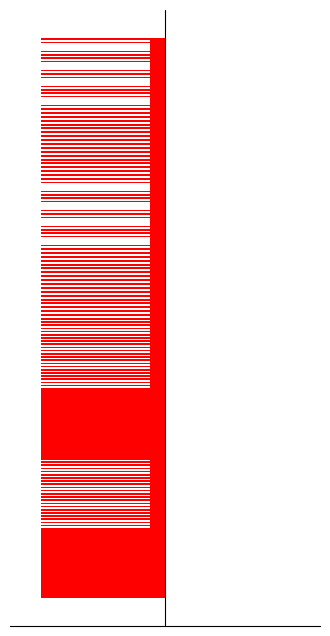

In [111]:
dict_w = {}
for i in range(2**16):
    num = format(i, '016b')
    """if num in (counts_h[2].keys()):
        if num[8] == '1' and num[14] == '1':
            dict_w[num] = 0.1
        elif num[10] == '1' and num[12] == '1':
            dict_w[num] = 0.1
        if num[4] == '1' and num[10] == '1':
            dict_w[num] = 0.1
        elif num[6] == '1' and num[8] == '1':
            dict_w[num] = 0.1
        if num[0] == '1' and num[6] == '1':
            dict_w[num] = 0.1
        elif num[2] == '1' and num[4] == '1':
            dict_w[num] = 0.1
        if num[0] == '1' and num[14] == '1':
            dict_w[num] = 0.1
        elif num[2] == '1' and num[12] == '1':
            dict_w[num] = 0.1
        else:
            dict_w[num] = -0.1
        dict_w[num] = 0.1*random.sample([1, -1], 1)[0]
    else:
        dict_w[num] = 0"""
    if num[8] == '1' and num[14] == '1':
        dict_w[num] = -0.1
    elif num[10] == '1' and num[12] == '1':
        dict_w[num] = -0.1
    if num[4] == '1' and num[10] == '1':
        dict_w[num] = -0.1
    elif num[6] == '1' and num[8] == '1':
        dict_w[num] = -0.1
    if num[0] == '1' and num[6] == '1':
        dict_w[num] = -0.1
    elif num[2] == '1' and num[4] == '1':
        dict_w[num] = -0.1
    if num[0] == '1' and num[14] == '1':
        dict_w[num] = -0.1
    elif num[2] == '1' and num[12] == '1':
        dict_w[num] = -0.1
    else:
        dict_w[num] = -0.8
"""values = [-0.5]*3000
rand_q = random.sample(range(3000), 800)
for i in rand_q:
    values[i] = -0.1#*random.sample([-1, 1], 1)[0]"""
values = list(dict_w.values())
#values.reverse()
#values[0] = 0.9
h_bar_plot(range(2**16), values)

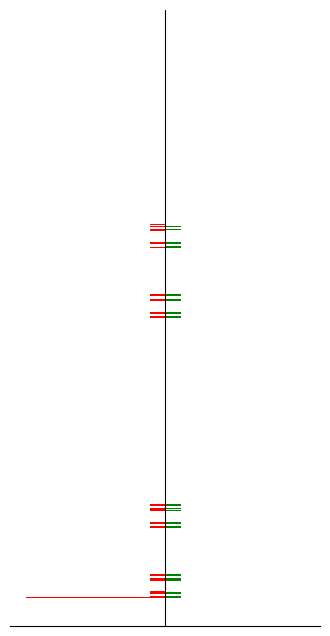

In [108]:
values[0] = -0.9
h_bar_plot(range(2**16), values)

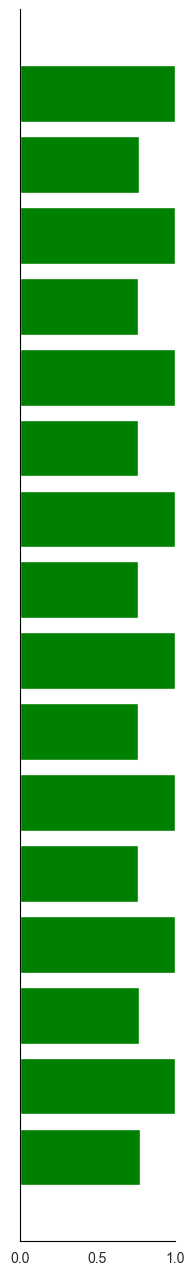

In [114]:
num_one = np.zeros(n**2)
for bitstring, count in counts_after_X.items():
    for i in range(n**2):
        num_one[i] += int(bitstring[i])*count
num_one = num_one/10000

# 사각형 플롯 생성
fig, ax = plt.subplots(figsize=(2, 16))

# 각 값을 사각형에 채워진 비율로 플롯
bars = ax.barh(range(len(num_one)), num_one, color='green')

# 사각형에 비율로 색상 채우기
for bar, value in zip(bars, num_one):
    bar.set_width(value)

# y축 눈금과 라벨 제거
ax.set_yticks(range(len(num_one)))
ax.set_yticklabels([])
ax.set_xticks([0, 0.5, 1])  # 0, 0.5, 1 라벨만 표시
ax.set_xlim(0, 1)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)

# 그래프 표시
plt.show()